In [8]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [9]:
import os

destination_dir = '/content/sample_data/casia2'
os.makedirs(destination_dir, exist_ok=True)

zip_path = '/content/drive/MyDrive/CASIA2.zip'
!unzip -q {zip_path} -d {destination_dir}

# List the contents of the destination directory to verify extraction
!ls {destination_dir}


'unzip' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import pickle as pkl

from tensorflow.keras.layers import Input
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
import torch
import torch.nn as nn
import keras
from keras.utils import plot_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization



from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from PIL import Image, ImageChops, ImageEnhance
from sklearn.utils import shuffle
import tensorflow as tf

c:\Users\abhis\anaconda3\envs\new_environment\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
fake_image_data={'image_path':[],'label':[],'image_id':[]}
fake_image_path='./Tp'
for img in os.listdir(fake_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=fake_image_path+"/"+str(img)
      fake_image_data['image_path'].append(temp_path)
      fake_image_data['label'].append('fake')
      fake_image_data['image_id'].append(img[:-4])

In [9]:
fake_image_data=pd.DataFrame(fake_image_data)
fake_image_data.head()

,image_path,label,image_id
0,./Tp/Tp_D_CND_S_N_txt00028_txt00006_10848.jpg,fake,Tp_D_CND_S_N_txt00028_txt00006_10848
1,./Tp/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg,fake,Tp_D_CNN_M_B_nat00056_nat00099_11105
2,./Tp/Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg,fake,Tp_D_CNN_M_B_nat10139_nat00059_11949
3,./Tp/Tp_D_CNN_M_B_nat10139_nat00097_11948.jpg,fake,Tp_D_CNN_M_B_nat10139_nat00097_11948
4,./Tp/Tp_D_CNN_M_N_ani00052_ani00054_11130.jpg,fake,Tp_D_CNN_M_N_ani00052_ani00054_11130


In [10]:
print("Number of fake images are {}".format(fake_image_data.shape[0]))


Number of fake images are 2064


In [11]:
real_image_data={'image_path':[],'label':[],'image_id':[]}
real_image_path='./Au'
for img in os.listdir(real_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=real_image_path+"/"+str(img)
      real_image_data['image_path'].append(temp_path)
      real_image_data['label'].append('real')
      real_image_data['image_id'].append(img[:-4])

In [12]:
real_image_data=pd.DataFrame(real_image_data)
real_image_data.head()

,image_path,label,image_id
0,./Au/Au_ani_00001.jpg,real,Au_ani_00001
1,./Au/Au_ani_00002.jpg,real,Au_ani_00002
2,./Au/Au_ani_00003.jpg,real,Au_ani_00003
3,./Au/Au_ani_00004.jpg,real,Au_ani_00004
4,./Au/Au_ani_00005.jpg,real,Au_ani_00005


In [13]:
print("Number of real images are {}".format(real_image_data.shape[0]))

Number of real images are 7437


In [14]:
real_image_data=shuffle(real_image_data,random_state=42)
real_image_data=real_image_data.iloc[:fake_image_data.shape[0],:]
final_image_data=pd.concat([fake_image_data,real_image_data])
len(final_image_data)
final_image_data

,image_path,label,image_id
0,./Tp/Tp_D_CND_S_N_txt00028_txt00006_10848.jpg,fake,Tp_D_CND_S_N_txt00028_txt00006_10848
1,./Tp/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg,fake,Tp_D_CNN_M_B_nat00056_nat00099_11105
2,./Tp/Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg,fake,Tp_D_CNN_M_B_nat10139_nat00059_11949
3,./Tp/Tp_D_CNN_M_B_nat10139_nat00097_11948.jpg,fake,Tp_D_CNN_M_B_nat10139_nat00097_11948
4,./Tp/Tp_D_CNN_M_N_ani00052_ani00054_11130.jpg,fake,Tp_D_CNN_M_N_ani00052_ani00054_11130
...,...,...,...
4639,./Au/Au_nat_30010.jpg,real,Au_nat_30010
4726,./Au/Au_nat_30097.jpg,real,Au_nat_30097
6123,./Au/Au_pla_30530.jpg,real,Au_pla_30530
2550,./Au/Au_art_30165.jpg,real,Au_art_30165


In [15]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [16]:
image_size = (128, 128)

def prepare_image(image_path):
  return np.array(convert_to_ela_image(image_path, 85).resize(image_size)) / 255.0

In [17]:
X=[]
Y=[]
for index,rows in tqdm(final_image_data.iterrows()):
    temp_ela_image=prepare_image(rows['image_path'])
    X.append(temp_ela_image)
    if rows['label']=='fake' :
        Y.append(0)
    else :
        Y.append(1)

4128it [01:02, 66.48it/s]


In [21]:
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=42)

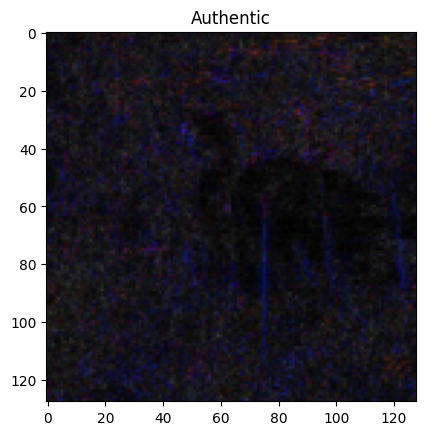

In [22]:
import matplotlib.pyplot as plt
import numpy as np

ran_num=np.random.randint(0, len(X_train))
img=X_train[ran_num]
title=""
if Y_train[ran_num]==0:
  title="Fake"
else:
  title="Authentic"
plt.title(title)
plt.imshow(img)

In [14]:
print(len(X_train))
print(len(X_val))
print(len(Y_train))
print(len(Y_val))

3302
826
3302
826


In [23]:
class Dataset:
    def __init__(self, data_x,data_y):
        self.x = []
        self.y = []

        for img in data_x :
            self.x.append(img)

        for lab in data_y :
            self.y.append(lab)


    def __getitem__(self, i):

        return self.x[i],self.y[i]


    def __len__(self): # your model.fit_gen requires this function
        return len(self.x)


class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1,shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indexes = np.arange(len(self.dataset.x))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        #batch = [for samples in zip(*data)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple([batch[0],batch[1]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

train_dataset=Dataset(X_train,Y_train)
train_dataloader = Dataloder(train_dataset, batch_size=8,shuffle=True)

test_dataset=Dataset(X_val,Y_val)
test_dataloader = Dataloder(test_dataset, batch_size=8,shuffle=True)

In [16]:
from tensorflow.keras.models import Model

Input_shape=Input(shape=(128,128,3))
conv11=Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu")(Input_shape)
conv12=Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(conv11)
conv13=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv12)
conv13=Dropout(0.3)(conv13)


flatten1=Flatten()(conv13)
dense1=Dense(units=16,activation="relu")(flatten1)
dense2=Dense(units=8,activation="relu")(dense1)
output=Dense(units=1, activation="sigmoid")(dense2)

model_1=Model(inputs=Input_shape,outputs=output)
print(model_1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                             

In [17]:
plot_model(model_1, show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [27]:
model_1.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [28]:
def scheduler(epoch,lr) :
  if epoch%5==0 :
    lr=0.9*lr

  return lr
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)

In [29]:
hist=model_1.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//8, validation_data=test_dataloader, validation_steps=len(test_dataloader)//8, epochs=30, callbacks=lrScheduler)

C:\Users\abhis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/30
51/51 [==============================] - 12s 63ms/step - loss: 0.6653 - accuracy: 0.4755 - val_loss: 0.6716 - val_accuracy: 0.3854 - lr: 9.0000e-05
Epoch 2/30
51/51 [==============================] - 3s 51ms/step - loss: 0.6100 - accuracy: 0.5931 - val_loss: 0.5409 - val_accuracy: 0.8958 - lr: 9.0000e-05
Epoch 3/30
51/51 [==============================] - 3s 52ms/step - loss: 0.4867 - accuracy: 0.8186 - val_loss: 0.4173 - val_accuracy: 0.8750 - lr: 9.0000e-05
Epoch 4/30
51/51 [==============================] - 3s 52ms/step - loss: 0.3942 - accuracy: 0.8578 - val_loss: 0.3658 - val_accuracy: 0.8750 - lr: 9.0000e-05
Epoch 5/30
51/51 [==============================] - 3s 52ms/step - loss: 0.3999 - accuracy: 0.8284 - val_loss: 0.3616 - val_accuracy: 0.8958 - lr: 9.0000e-05
Epoch 6/30
51/51 [==============================] - 3s 52ms/step - loss: 0.3341 - accuracy: 0.8750 - val_loss: 0.4302 - val_accuracy: 0.7708 - lr: 8.1000e-05
Epoch 7/30
51/51 [==============================] -

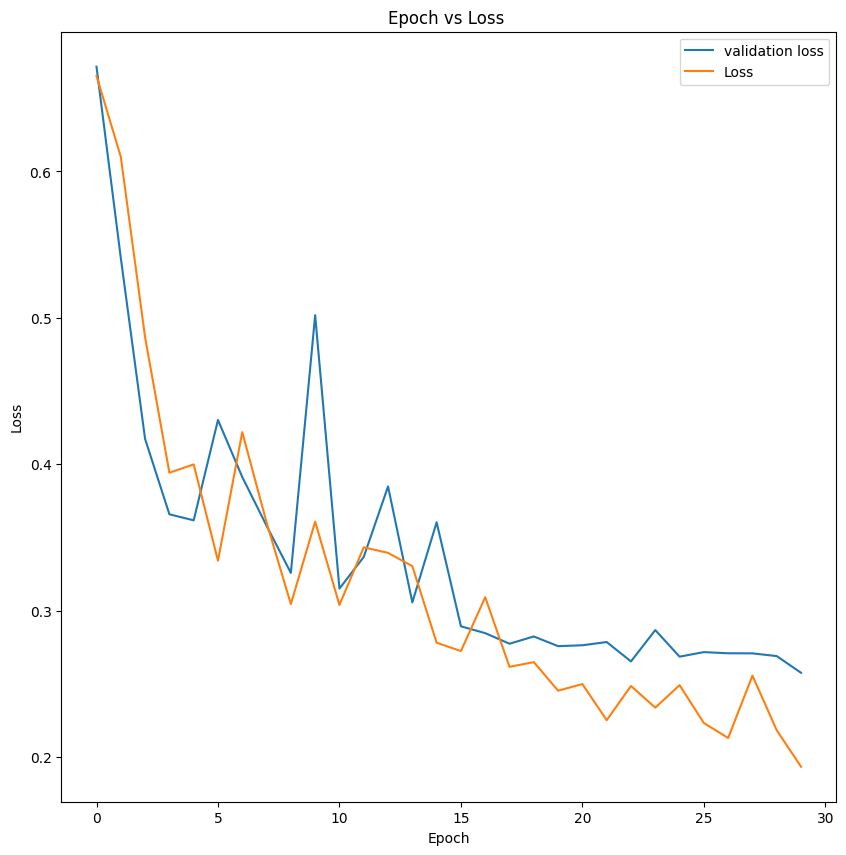

In [30]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['val_loss'], label='validation loss')
plt.plot(hist.history['loss'], label='Loss')
plt.title('Epoch vs Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

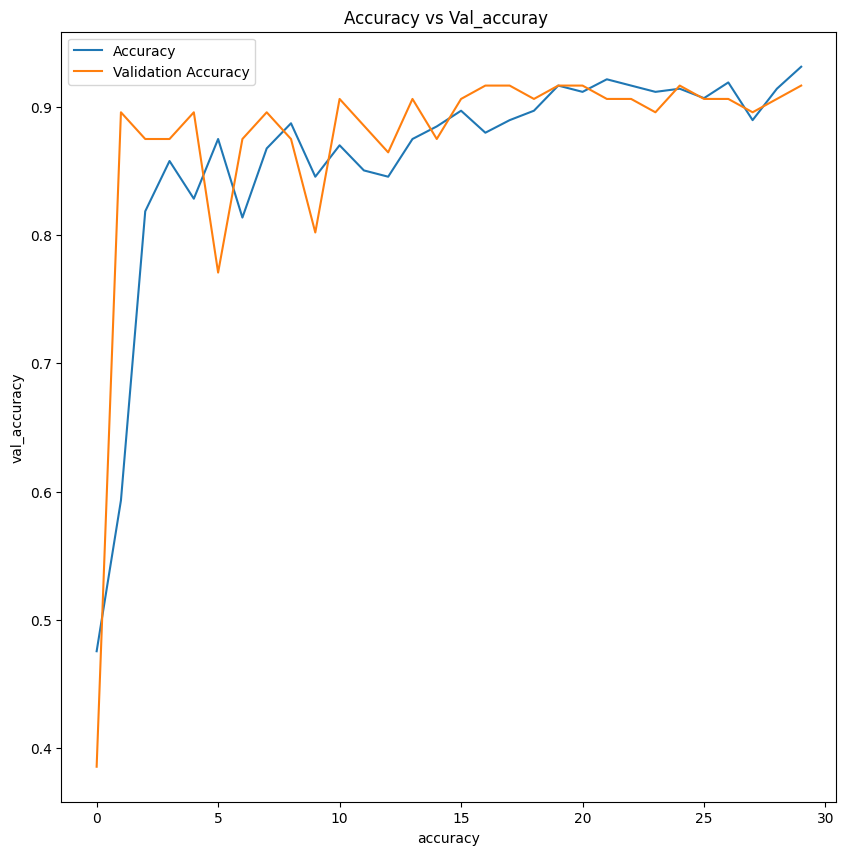

In [31]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Val_accuray ')
plt.xlabel('accuracy')
plt.ylabel('val_accuracy')
plt.legend()
plt.show()

In [32]:
model_1.save("v1model_final.h5")

In [19]:
from tensorflow.keras.models import load_model

def predict(img_path,model) :
    pi=prepare_image(img_path)
    pi=pi.reshape(1,128,128,3)
    predict=model.predict(pi)
    return predict

model=load_model('v1model_final.h5')


100%|██████████| 999/999 [01:29<00:00, 11.12it/s]


Accuracy: 0.923923923923924
F1 Score: 0.9164835164835166


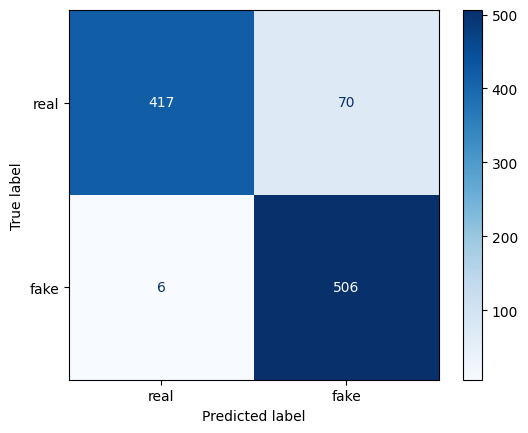

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from tqdm import tqdm
import contextlib
import os
import sys

# Function to suppress print statements
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Assuming final_image_data is a DataFrame with 'image_path' and 'label' columns
# And 'predict' is a function that takes an image path and model, and returns a prediction

true_labels = []
predictions = []

for i in tqdm(range(1, 1000)):
    ran_num = np.random.randint(0, final_image_data.shape[0])
    temp_row = final_image_data.iloc[ran_num, :]

    # Suppress output for reading the image and making predictions
    with suppress_output():
        temp_arr = plt.imread(temp_row['image_path'])
        temp_predict = predict(temp_row['image_path'], model)

    if temp_predict[0] > 0.5:
        temp_prediction = 'real'
    else:
        temp_prediction = 'fake'

    true_labels.append(temp_row['label'])
    predictions.append(temp_prediction)

# Calculate the confusion matrix
labels = ['real', 'fake']
cm = confusion_matrix(true_labels, predictions, labels=labels)

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, pos_label='real')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, pos_label='real')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.923923923923924
F1 Score: 0.9164835164835166


419 54 453 73
0.8516260162601627
0.6143695014662757


In [22]:
img_path='./data_2/test_data'
for i in os.listdir(img_path) :
  ran_num=np.random.randint(0, len(os.listdir(img_path)))
  print("="*100)
  temp_arr=plt.imread(img_path+'/'+i)
  print("Real label--- {}".format(i))
  temp_predict=predict(img_path+'/'+i,model_1)
  if temp_predict[0]>0.5 :
    temp_prediction='real'
  else:
    temp_prediction='fake'
  print(temp_predict[0])
  print("Predicted label--- {}".format(temp_prediction))

Real label--- Au_0.png
1/1 [==============================] - 0s 32ms/step
[0.4986253]
Predicted label--- fake
Real label--- Au_1.png
1/1 [==============================] - 0s 31ms/step
[0.49967453]
Predicted label--- fake
Real label--- Au_10.png
1/1 [==============================] - 0s 16ms/step
[0.50004685]
Predicted label--- real
Real label--- Au_17.png
1/1 [==============================] - 0s 31ms/step
[0.5041626]
Predicted label--- real
Real label--- Au_18.png
1/1 [==============================] - 0s 16ms/step
[0.49938184]
Predicted label--- fake
Real label--- Au_19.png
1/1 [==============================] - 0s 16ms/step
[0.4988982]
Predicted label--- fake
Real label--- Au_2.png
1/1 [==============================] - 0s 16ms/step
[0.5007005]
Predicted label--- real
Real label--- Au_20.png
1/1 [==============================] - 0s 31ms/step
[0.50157166]
Predicted label--- real
Real label--- Au_21.png
1/1 [==============================] - 0s 31ms/step
[0.4976337]
Predicted label

In [ ]:
!pip install segmentation_models keras==2.10 tensorflow==2.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

In [24]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow.keras.optimizers import *
from tqdm import tqdm
import cv2
import segmentation_models as sm
%load_ext tensorboard
import datetime
from keras.utils import plot_model

Segmentation Models: using `keras` framework.


In [25]:
fake_image_data={'image_path':[],'label':[],'image_id':[]}

fake_image_path='./Tp'
for img in os.listdir(fake_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=fake_image_path+"/"+str(img)
      fake_image_data['image_path'].append(temp_path)
      fake_image_data['label'].append('fake')
      fake_image_data['image_id'].append(img[:-4])

In [26]:
fake_image_data=pd.DataFrame(fake_image_data)
fake_image_data.head()

,image_path,label,image_id
0,./Tp/Tp_D_CND_S_N_txt00028_txt00006_10848.jpg,fake,Tp_D_CND_S_N_txt00028_txt00006_10848
1,./Tp/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg,fake,Tp_D_CNN_M_B_nat00056_nat00099_11105
2,./Tp/Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg,fake,Tp_D_CNN_M_B_nat10139_nat00059_11949
3,./Tp/Tp_D_CNN_M_B_nat10139_nat00097_11948.jpg,fake,Tp_D_CNN_M_B_nat10139_nat00097_11948
4,./Tp/Tp_D_CNN_M_N_ani00052_ani00054_11130.jpg,fake,Tp_D_CNN_M_N_ani00052_ani00054_11130


In [27]:
fake_image_mask={'image_id':[],'mask_image_path':[]}
fake_image_mask_path='./CASIA 2 Groundtruth'
for file in os.listdir(fake_image_mask_path):
    if file.endswith('jpg') or file.endswith('png') :
      temp_path=fake_image_mask_path+"/"+str(file)
      fake_image_mask['mask_image_path'].append(temp_path)
      fake_image_mask['image_id'].append(file[:-7])

In [28]:
fake_image_mask=pd.DataFrame(fake_image_mask)
fake_image_mask.head()

,image_id,mask_image_path
0,Tp_D_CND_M_N_ani00018_sec00096_00138,./CASIA 2 Groundtruth/Tp_D_CND_M_N_ani00018_se...
1,Tp_D_CND_M_N_art00076_art00077_10289,./CASIA 2 Groundtruth/Tp_D_CND_M_N_art00076_ar...
2,Tp_D_CND_M_N_art00077_art00076_10290,./CASIA 2 Groundtruth/Tp_D_CND_M_N_art00077_ar...
3,Tp_D_CND_S_N_ani00073_ani00068_00193,./CASIA 2 Groundtruth/Tp_D_CND_S_N_ani00073_an...
4,Tp_D_CND_S_N_ind00078_ind00077_00476,./CASIA 2 Groundtruth/Tp_D_CND_S_N_ind00078_in...


In [29]:
fake_image_data=fake_image_data.merge(fake_image_mask, on='image_id')
fake_image_data.tail()

,image_path,label,image_id,mask_image_path
1999,./Tp/Tp_S_NRN_S_O_ani10103_ani10103_10634.jpg,fake,Tp_S_NRN_S_O_ani10103_ani10103_10634,./CASIA 2 Groundtruth/Tp_S_NRN_S_O_ani10103_an...
2000,./Tp/Tp_S_NRN_S_O_arc10129_arc10129_11895.jpg,fake,Tp_S_NRN_S_O_arc10129_arc10129_11895,./CASIA 2 Groundtruth/Tp_S_NRN_S_O_arc10129_ar...
2001,./Tp/Tp_S_NRN_S_O_cha00077_cha00077_11017.jpg,fake,Tp_S_NRN_S_O_cha00077_cha00077_11017,./CASIA 2 Groundtruth/Tp_S_NRN_S_O_cha00077_ch...
2002,./Tp/Tp_S_NRN_S_O_cha10126_cha10126_12153.jpg,fake,Tp_S_NRN_S_O_cha10126_cha10126_12153,./CASIA 2 Groundtruth/Tp_S_NRN_S_O_cha10126_ch...
2003,./Tp/Tp_S_NRN_S_O_cha10187_cha10187_12308.jpg,fake,Tp_S_NRN_S_O_cha10187_cha10187_12308,./CASIA 2 Groundtruth/Tp_S_NRN_S_O_cha10187_ch...


In [30]:
fake_image_data.shape[0]

2004

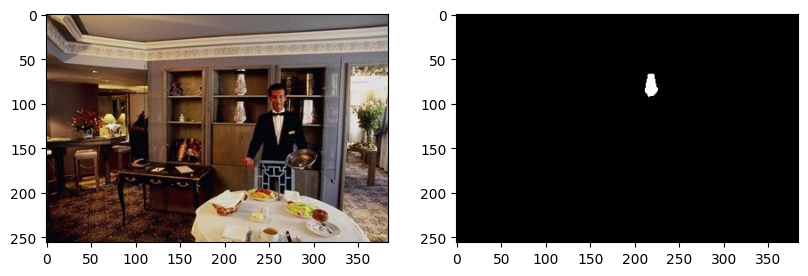

In [31]:
ran_num=np.random.randint(0, fake_image_data.shape[0])
fig=plt.figure(figsize=(15, 15))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
temp_arr=Image.open(fake_image_data.iloc[ran_num]['image_path'])
temp_mask_arr=cv2.imread(fake_image_data.iloc[ran_num]['mask_image_path'])
ax1.imshow(temp_arr)
ax2.imshow(temp_mask_arr, cmap='gray')

In [32]:
def change_pixel_value(A) :
    if len(A.shape)==3 :
        A=A[:,:,0]
    #Intilize a array B
    B=np.zeros((A.shape[0],A.shape[1]))
    for i in range(A.shape[0]) :
        for j in range(A.shape[1]) :
            if A[i][j]==255 :
                B[i][j]=0.0
            else :
                B[i][j]=1.0
    return B

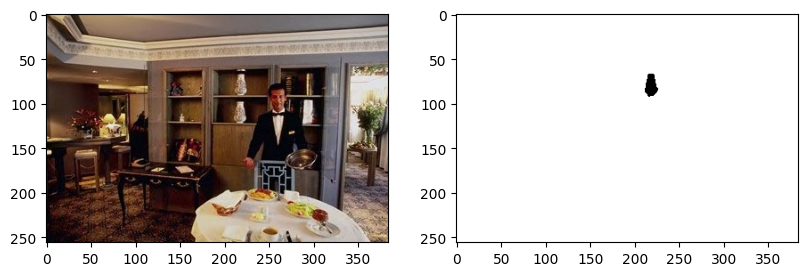

In [33]:
fig=plt.figure(figsize=(15, 15))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
temp_mask_arr=change_pixel_value(temp_mask_arr)
ax1.imshow(temp_arr)
ax2.imshow(temp_mask_arr, cmap='gray')

In [34]:
from sklearn.model_selection import train_test_split
train, validation=train_test_split(fake_image_data, random_state=42, test_size=0.2, stratify=fake_image_data['label'])

In [35]:
import numpy as np
q = [4.0, 12.0, 2.0]
filter1 = [[0, 0, 0, 0, 0],
           [0, -1, 2, -1, 0],
           [0, 2, -4, 2, 0],
           [0, -1, 2, -1, 0],
           [0, 0, 0, 0, 0]]
filter2 = [[-1, 2, -2, 2, -1],
           [2, -6, 8, -6, 2],
           [-2, 8, -12, 8, -2],
           [2, -6, 8, -6, 2],
           [-1, 2, -2, 2, -1]]
filter3 = [[0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 1, -2, 1, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]]


filter1 = np.asarray(filter1, dtype=float) / q[0]
filter2 = np.asarray(filter2, dtype=float) / q[1]
filter3 = np.asarray(filter3, dtype=float) / q[2]

filters = filter1+filter2+filter3

In [36]:
class Dataset:
    def __init__(self, data):
        self.image_path = []
        self.mask_image_path = []

        for index,rows in data.iterrows() :
            self.image_path.append(rows['image_path'])
            self.mask_image_path.append(rows['mask_image_path'])


    def __getitem__(self, i):
        #Load images
        img=cv2.imread(self.image_path[i],cv2.IMREAD_UNCHANGED)
        mask_img=cv2.imread(self.mask_image_path[i],0)
        #Converting image to 512,512,3
        #after analyzing i found a single image with 512*512*4
        if img.shape[-1]!=3 :
            img=cv2.resize(img[:,:,:3],(512,512))
        else :
            img=cv2.resize(img,(512,512))
        #Converting mask image into 512*512
        #We observe some image are 2-d only some are 3-d
        if len(mask_img.shape)==2 :
            mask_img=cv2.resize(mask_img,(512,512))
        else :
            mask_img=cv2.resize(mask_img[:,:,0],(512,512))

        #Processed image
        preprocess_img=cv2.filter2D(img,-1,filters)
        #process mask image
        mask_img_mod=change_pixel_value(mask_img)




        return img,preprocess_img,mask_img_mod


    def __len__(self): # your model.fit_gen requires this function
        return len(self.image_path)


class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1,shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indexes = np.arange(len(self.dataset.image_path))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        #batch = [for samples in zip(*data)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        batch[2]=batch[2].reshape((self.batch_size,512,512,1))

        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

train_dataset=Dataset(train)
train_dataloader = Dataloder(train_dataset, batch_size=8,shuffle=True)

In [37]:
def conv2d_block(input_dim, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same") (input_dim)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

#This part is for input image

input_img = Input((512, 512, 3))
# contracting path
conv11 = conv2d_block(input_img, n_filters=16, kernel_size=3, batchnorm=True)
pool11 = MaxPooling2D((2, 2)) (conv11)
pool11 = Dropout(0.5)(pool11)
conv12 = conv2d_block(pool11, n_filters=32, kernel_size=3, batchnorm=True)
pool12 = MaxPooling2D((2, 2)) (conv12)
pool12 = Dropout(0.5)(pool12)
conv13 = conv2d_block(pool12, n_filters=64, kernel_size=3, batchnorm=True)
pool13 = MaxPooling2D((2, 2)) (conv13)
pool13 = Dropout(0.5)(pool13)
conv14 = conv2d_block(pool13, n_filters=128, kernel_size=3, batchnorm=True)
pool14 = MaxPooling2D(pool_size=(2, 2)) (conv14)
pool14 = Dropout(0.5)(pool14)
conv15 = conv2d_block(pool14, n_filters=256, kernel_size=3, batchnorm=True)
#Expanding path
u6 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same') (conv15)
#skip_connections
u6 = concatenate([u6, conv14])
u6 = Dropout(0.5)(u6)
c6 = conv2d_block(u6, n_filters=128, kernel_size=3, batchnorm=True)
u7 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, conv13])
u7 = Dropout(0.5)(u7)
c7 = conv2d_block(u7, n_filters=64, kernel_size=3, batchnorm=True)
u8 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, conv12])
u8 = Dropout(0.5)(u8)
c8 = conv2d_block(u8, n_filters=32, kernel_size=3, batchnorm=True)
u9 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, conv11], axis=3)
u9 = Dropout(0.5)(u9)
c9 = conv2d_block(u9, n_filters=16, kernel_size=3, batchnorm=True)

output = Conv2D(3, (1, 1), activation='sigmoid') (c9)


#This part is for SRM filter output image

input_img_filter = Input((512, 512, 3))

# contracting path
conv21 = conv2d_block(input_img_filter, n_filters=16, kernel_size=3, batchnorm=True)
pool21 = MaxPooling2D((2, 2)) (conv21)
pool21 = Dropout(0.5)(pool21)
conv22 = conv2d_block(pool21, n_filters=32, kernel_size=3, batchnorm=True)
pool22 = MaxPooling2D((2, 2)) (conv22)
pool22 = Dropout(0.5)(pool22)
conv23 = conv2d_block(pool22, n_filters=64, kernel_size=3, batchnorm=True)
pool23 = MaxPooling2D((2, 2)) (conv23)
pool23 = Dropout(0.5)(pool23)
conv24 = conv2d_block(pool23, n_filters=128, kernel_size=3, batchnorm=True)
pool24 = MaxPooling2D(pool_size=(2, 2)) (conv24)
pool24 = Dropout(0.5)(pool24)
conv25 = conv2d_block(pool24, n_filters=256, kernel_size=3, batchnorm=True)
#Expanding path
u6 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same') (conv25)
#skip_connections
u6 = concatenate([u6, conv24])
u6 = Dropout(0.5)(u6)
c6 = conv2d_block(u6, n_filters=128, kernel_size=3, batchnorm=True)
u7 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, conv23])
u7 = Dropout(0.5)(u7)
c7 = conv2d_block(u7, n_filters=64, kernel_size=3, batchnorm=True)
u8 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, conv22])
u8 = Dropout(0.5)(u8)
c8 = conv2d_block(u8, n_filters=32, kernel_size=3, batchnorm=True)
u9 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, conv11], axis=3)
u9 = Dropout(0.5)(u9)
c9 = conv2d_block(u9, n_filters=16, kernel_size=3, batchnorm=True)

output_filter = Conv2D(3, (1, 1), activation='sigmoid') (c9)

combined = concatenate([output, output_filter])
outputs = Conv2D(1, (1, 1), activation='sigmoid') (combined)

model_2 = Model(inputs=[input_img,input_img_filter], outputs=[outputs])

In [38]:
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                             

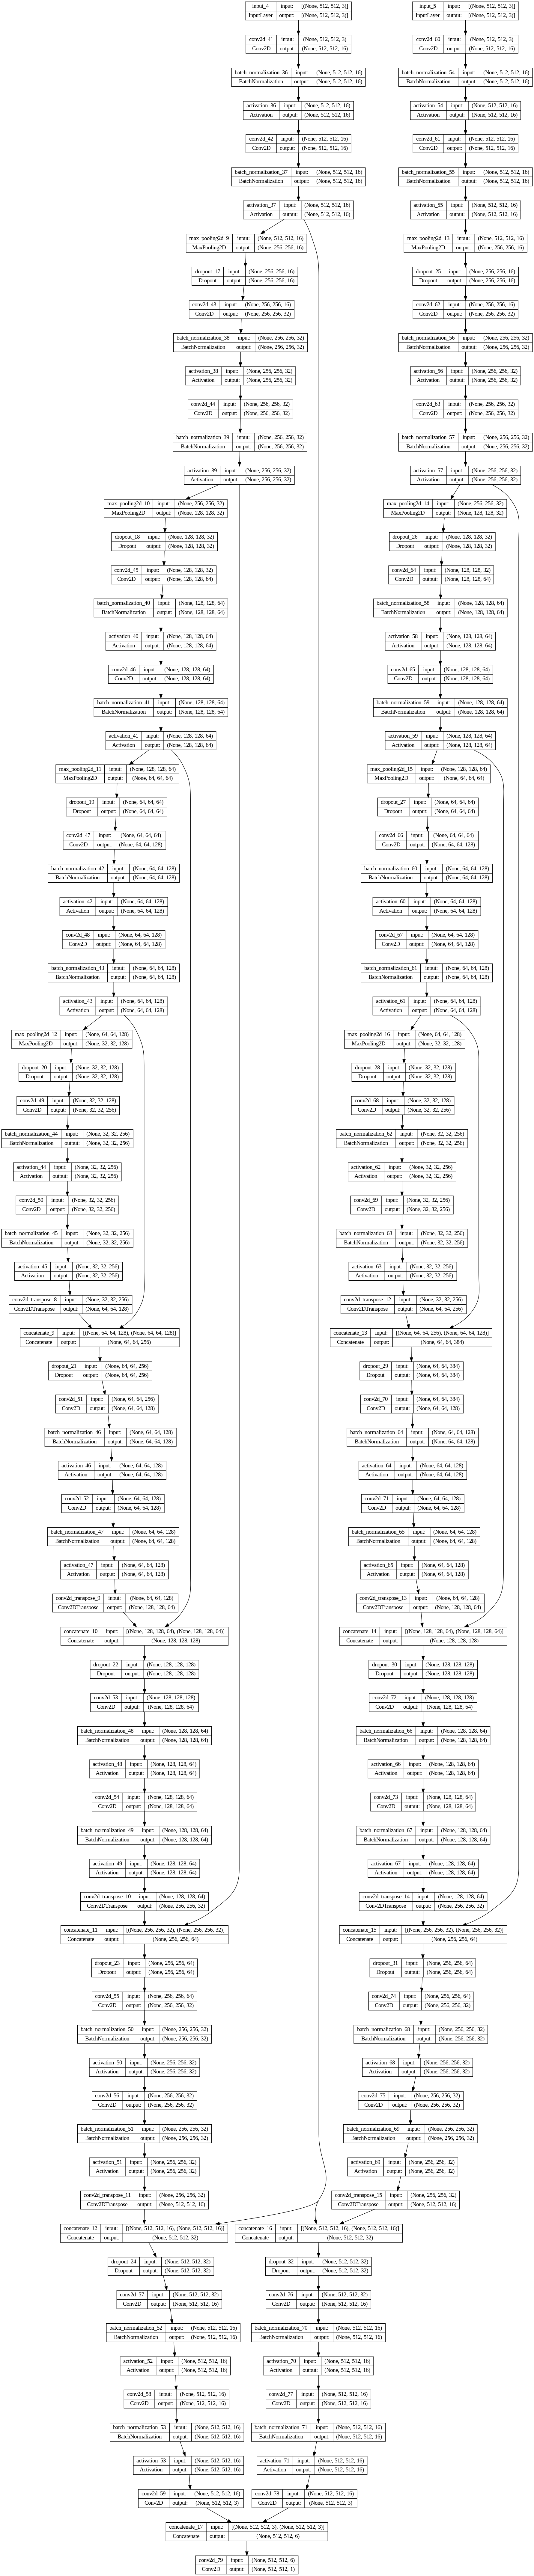

In [ ]:
plot_model(model_2, show_shapes=True, show_layer_names=True)

In [36]:
def scheduler(epoch,lr) :
  if epoch%5==0 :
    lr=0.9*lr

  return lr

#Callbacks
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_2.compile(optimizer='adam', loss="binary_crossentropy", metrics=[sm.metrics.iou_score])

In [ ]:
hist=model_2.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader)//8, validation_data=test_dataloader, validation_steps=len(test_dataloader)//8, epochs=10, callbacks=lrScheduler)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.8124 - iou_score: 0.4140 

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_2" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>]


In [57]:
doubleunetmodel_json = model.to_json()
with open("doubleunetmodel_json.json", "w") as json_file:
    json_file.write(doubleunetmodel_json)

In [39]:
model_2.load_weights('dunet.h5')

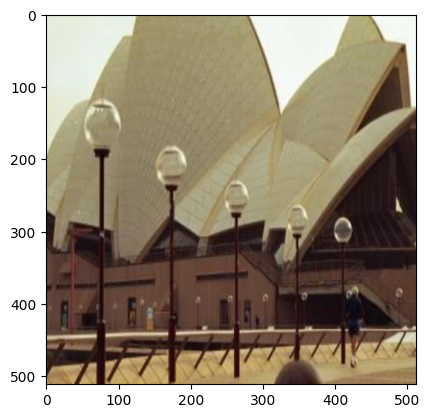

In [45]:
ran_num=np.random.randint(0,fake_image_data.shape[0])
image_arr=np.array(Image.open(fake_image_data.iloc[ran_num]['image_path']))
mask_arr=np.array(Image.open(fake_image_data.iloc[ran_num]['mask_image_path']))
mask_arr_mod=change_pixel_value(mask_arr)
img_arr=cv2.resize(image_arr,(512,512))
preprocess_img=cv2.filter2D(img_arr,-1,filters)
preprocess_img=cv2.resize(preprocess_img,(512,512))
img_arr=img_arr.reshape(1,512,512,3)
preprocess_img=preprocess_img.reshape(1,512,512,3)
plt.imshow(img_arr[0])

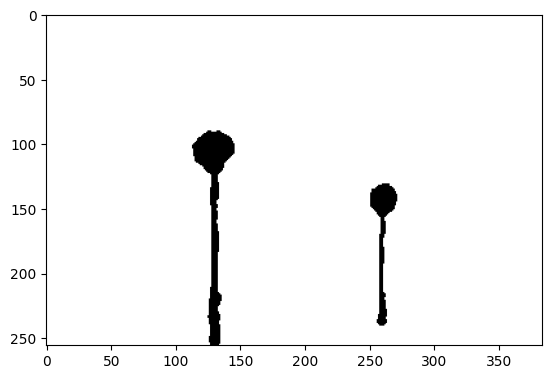

In [46]:
plt.imshow(mask_arr_mod,cmap='gray')

In [47]:
pred=model_2.predict([img_arr,preprocess_img])[0]
pred=pred.reshape(512,512)

In [51]:
for i in range(pred.shape[0]) :
    for j in range(pred.shape[1]) :
        if pred[i][j]>0.75 :
            pred[i][j]=1.0
        else :
            pred[i][j]=0.0

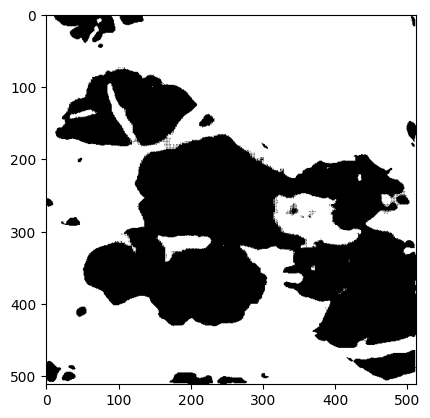

In [52]:
plt.imshow(pred,cmap='gray')